# Textual Entailments

Textual Entailment is a generalization of many tasks in natural language processing. If you have a system that is good at recognizing textual entailment, it should be easier to build good systems for information retrieval, question answering, paraphrase recognition, information extraction and summarization.


## Task

Given two text fragments, one named text and the other named hypothesis, the task consists in recognizing whether the hypothesis can be inferred from the text.

## Dataset

The Multi-genre NLI Corpus (RepEval 2017) [http://www.nyu.edu/projects/bowman/multinli/] will be used to create the model. The sentence pairs are presented. From source text and promted to...

In [1]:
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

import os
from os.path import join, exists
import sys
import numpy as np
import time

import urllib2
import json
from zipfile import ZipFile

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

import tensorflow as tf

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, Dense, Input, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, Layer, Merge, LSTM, Bidirectional, Convolution1D, GRU, add, concatenate
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, BaseLogger, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

/home/ramit/anaconda2/envs/keras/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramit/anaconda2/envs/keras/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ramit/anaconda2/envs/keras/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ramit/anaconda2/envs/keras/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In fu

In [2]:
dataset_filename = 'multinli_0.9'
training_sample_size = 1000 # Change this to -1 if you want all
max_seq_length = 20 # max 400

model_name = 'small'

lr = 0.001
lr_decay = 1e-4
epochs = 10
batch_size = 32


# Download Dataset

In [3]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
    
def maybe_download(data_root, url, filename, expected_bytes, force=False):
    dest_filename = join(data_root, filename)

    if force or not exists(dest_filename):
        print('Attempting to download:', filename) 
        url_file = url + '/' + filename
        print(url_file)
        req = urllib2.Request(url_file)
        req.add_header('Accept', '*/*') # make file downloadable
        f = urllib2.urlopen(req)
        total_size = f.info().getheader('Content-Length').strip()
        total_size = int(total_size)
        chunk_size = int(total_size / 100)
        
        with open(dest_filename, "wb") as local_file:
            bytes_so_far = 0
            count = 0
            while bytes_so_far < total_size:
                chunk = f.read(chunk_size)
                local_file.write(chunk)
                bytes_so_far += len(chunk)

                download_progress_hook(count, chunk_size, total_size)
                count += 1
        #filename, _ = urllib2.urlretrieve(url + filename, dest_filename)#, reporthook=download_progress_hook)
        print('\nDownload Complete!')
        
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename + '. Can you get to it with a browser? ' + str(statinfo.st_size))
    
    return dest_filename


In [4]:
multinli_url = 'http://www.nyu.edu/projects/bowman/multinli'
data_folder = './datasets'

if not exists(data_folder):
    os.makedirs(data_folder)

train_filename_zip = maybe_download(data_folder, multinli_url, dataset_filename + '.zip', 227262128)

train_filename = os.path.join(data_folder, dataset_filename, dataset_filename + '_train.jsonl')
if not exists(train_filename):
    print('Extract %s' % train_filename_zip)
    zipfile = ZipFile(train_filename_zip, 'r')
    zipfile.extractall(data_folder)
    zipfile.close()

Found and verified ./datasets/multinli_0.9.zip


# Download GloVe

In [5]:
glove_url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
embedding_dim = 300
glove_filename = 'glove.840B.' + str(embedding_dim) + 'd.zip'
glove_loc = join(data_folder, glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)

glove_filename = os.path.join(data_folder, 'glove.840B.300d.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:],dtype=np.float32)
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))
#print(embeddings)
 

Extract ./datasets/glove.840B.300d.txt
Embeddings size: 2196016


# Data Valuation

## Dataset Corpus

In [6]:
def loadDataset(filename, size=-1):
    label_category = {
        'neutral': 0,
        'entailment': 1,
        'contradiction': 2
    }
    dataset = []
    sentence1 = []
    sentence2 = []
    labels = []
    with open(filename, 'r') as f:
        i = 0
        not_found = 0
        for line in f:
            row = json.loads(unicode(line, 'utf-8'))
            if size == -1 or i < size:
                dataset.append(row)
                label = row['gold_label'].encode('utf-8').strip()
                if label in label_category:
                    sentence1.append( row['sentence1'].encode('utf-8').strip() )
                    sentence2.append( row['sentence2'].encode('utf-8').strip() )

                    labels.append( label_category[label] )
                    i += 1
                else:
                    not_found += 1
            else:
                break;
        if not_found > 0:
            print('Label not recognized %d' % not_found)
                
    return (dataset, sentence1, sentence2, labels)


(train_dataset, train_sentence1, train_sentence2, train_labels) = loadDataset(train_filename, training_sample_size)

train_df = pd.DataFrame(train_dataset)

train_df.head()

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],government,neutral,335730n,335730n,Conceptually cream skimming has two basic dime...,( ( Conceptually ( cream skimming ) ) ( ( has ...,(ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...,Product and geography are what make cream skim...,( ( ( Product and ) geography ) ( ( are ( what...,(ROOT (S (NP (NN Product) (CC and) (NN geograp...
1,[entailment],telephone,entailment,249628e,249628e,you know during the season and i guess at at y...,( you ( ( know ( during ( ( ( the season ) and...,(ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...,You lose the things to the following level if ...,( You ( ( ( ( lose ( the things ) ) ( to ( the...,(ROOT (S (NP (PRP You)) (VP (VBP lose) (NP (DT...
2,[entailment],fiction,entailment,169837e,169837e,One of our number will carry out your instruct...,( ( One ( of ( our number ) ) ) ( ( will ( ( (...,(ROOT (S (NP (NP (CD One)) (PP (IN of) (NP (PR...,A member of my team will execute your orders w...,( ( ( A member ) ( of ( my team ) ) ) ( ( will...,(ROOT (S (NP (NP (DT A) (NN member)) (PP (IN o...
3,[entailment],fiction,entailment,155402e,155402e,How do you know? All this is their information...,( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...,(ROOT (S (SBARQ (WHADVP (WRB How)) (SQ (VBP do...,This information belongs to them.,( ( This information ) ( ( belongs ( to them )...,(ROOT (S (NP (DT This) (NN information)) (VP (...
4,[neutral],telephone,neutral,416658n,416658n,yeah i tell you what though if you go price so...,( yeah ( i ( ( tell you ) ( what ( ( though ( ...,(ROOT (S (VP (VB yeah) (S (NP (FW i)) (VP (VB ...,The tennis shoes have a range of prices.,( ( The ( tennis shoes ) ) ( ( have ( ( a rang...,(ROOT (S (NP (DT The) (NN tennis) (NNS shoes))...


In [7]:
train_df.genre.unique()

array([u'government', u'telephone', u'fiction', u'travel', u'slate'],
      dtype=object)

In [8]:
train_df.gold_label.unique()

array([u'neutral', u'entailment', u'contradiction'], dtype=object)

In [9]:
gold_label = train_df['gold_label']
print('neutral: %d' % gold_label[gold_label == 'neutral'].count())
print('entailment: %d' % gold_label[gold_label == 'entailment'].count())
print('contradiction: %d' % gold_label[gold_label == 'contradiction'].count())


neutral: 282
entailment: 343
contradiction: 375


In [10]:
train_df.iloc[0]

annotator_labels                                                  [neutral]
genre                                                            government
gold_label                                                          neutral
pairID                                                              335730n
promptID                                                            335730n
sentence1                 Conceptually cream skimming has two basic dime...
sentence1_binary_parse    ( ( Conceptually ( cream skimming ) ) ( ( has ...
sentence1_parse           (ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...
sentence2                 Product and geography are what make cream skim...
sentence2_binary_parse    ( ( ( Product and ) geography ) ( ( are ( what...
sentence2_parse           (ROOT (S (NP (NN Product) (CC and) (NN geograp...
Name: 0, dtype: object

We would train model on sentence1, sentence2 and gold_label.

In [11]:
train_df_features = train_df[['sentence1', 'sentence2', 'gold_label']]
train_df_features

,sentence1,sentence2,gold_label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,neutral
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,entailment
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,entailment
3,How do you know? All this is their information...,This information belongs to them.,entailment
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,neutral
5,my walkman broke so i'm upset now i just have ...,I'm upset that my walkman broke and now I have...,entailment
6,But a few Christian mosaics survive above the ...,Most of the Christian mosaics were destroyed b...,neutral
7,(Read for Slate 's take on Jackson's findings.),Slate had an opinion on Jackson's findings.,entailment
8,Gays and lesbians.,Heterosexuals.,contradiction
9,At the end of Rue des Francs-Bourgeois is what...,Place des Vosges is constructed entirely of gr...,contradiction


In [12]:
train_df_features.iloc[23]

sentence1     well it's been very interesting
sentence2        It has been very intriguing.
gold_label                         entailment
Name: 23, dtype: object

In [13]:
if len(train_df_features) >= 392695:
    train_df_features.iloc[392695]

In [14]:
if len(train_df_features) >= 392694:
    train_df_features.iloc[392694]

In [15]:
if len(train_df_features) >= 392697:
    train_df_features.iloc[392697]

In [16]:
train_df_features.iloc[8]

sentence1     Gays and lesbians.
sentence2         Heterosexuals.
gold_label         contradiction
Name: 8, dtype: object

## Prepare Word Embeddings

In [41]:
NUM_WORDS = len(embeddings) #200000

print('Found %s samples.' % len(train_sentence1))

train_sentences = train_sentence1 + train_sentence2

tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(train_sentences)
sentence1_word_sequences = tokenizer.texts_to_sequences(train_sentence1)
sentence2_word_sequences = tokenizer.texts_to_sequences(train_sentence2)
word_index = tokenizer.word_index
a = 'the '
token = Tokenizer(num_words=)
token.fit_on_texts(a)
sequence = token.texts_to_sequences(a)
print(sequence)
#print('Found %s unique tokens.' % len(word_index))
#print(sentence1_word_sequences)
#print(sentence1_word_sequences)

Found 1000 samples.
[[3], [1], [2], []]


In [18]:
from collections import defaultdict

words_len = min(NUM_WORDS, len(word_index))
# word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
max_word_count_text = 0
text_count = defaultdict(int)
for sentence in sentence1_word_sequences:
    print('sent',sentence)
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

max_word_count_hypo = 0
hypo_count = defaultdict(int)
for sentence in sentence2_word_sequences:
    max_word_count_hypo = max(max_word_count_hypo, len(sentence))
    hypo_count[len(sentence)] += 1
        

sent [3369, 1852, 2341, 31, 81, 1058, 3356, 767, 3, 2143]
sent [11, 30, 285, 1, 1727, 3, 7, 382, 28, 28, 86, 245, 23, 11, 1416, 67, 2, 1, 274, 245, 43, 43, 16, 2177, 2, 1505, 1, 1, 4682, 324, 1, 3916, 2177, 2, 535, 2, 1505, 5, 521, 24, 1913, 5, 128, 5, 2893, 5, 521, 568, 59, 2, 890, 132, 3, 5, 923, 5, 521, 568, 59, 2, 890, 132]
sent [49, 4, 115, 302, 39, 1475, 72, 86, 5517, 5744]
sent [75, 36, 11, 30, 37, 34, 9, 42, 116, 550]
sent [56, 7, 344, 11, 47, 262, 43, 11, 105, 627, 77, 4, 147, 2419, 1469, 7, 50, 76, 419, 78, 11, 30, 119, 1195, 59, 6, 1, 782, 1089, 2935]
sent [58, 2268, 1370, 33, 70, 2292, 78, 7, 55, 15, 2, 689, 1, 1408, 59, 151, 1053]
sent [21, 5, 296, 875, 3035, 4453, 331, 1, 4470, 9, 1, 5257, 18, 1, 4805, 3638, 18, 1, 5247, 1538, 2, 1, 100, 51, 4713, 4253, 2, 1, 216, 31, 5268, 815, 12, 5, 296, 4491, 24, 51, 4208]
sent [305, 12, 895, 598, 133, 17, 2793, 601]
sent [3646, 3, 5475]
sent [28, 1, 191, 4, 4215, 829, 4610, 5612, 9, 47, 98, 733, 2, 20, 1, 732, 91, 3374, 513, 917, 1, 

sent [21, 128, 29, 315, 374, 10, 3, 3, 46, 1, 65, 322, 14, 284, 5279, 60, 60, 16, 179, 46, 23, 46, 676, 46, 659, 110, 8, 46, 2449, 18, 86, 537]
sent [6, 471, 3871, 13, 148, 87, 3345, 60, 581, 4979, 24, 1, 502, 4, 1, 158, 35, 148, 87, 238, 224, 1648, 2, 1, 502, 4, 1, 158]
sent [15, 11, 64, 3127, 2, 403, 159, 145, 29, 255, 72]
sent [3, 16, 1130, 475, 54, 138, 24, 159, 56, 45, 3, 113, 3, 16, 53, 15, 64, 1546, 2, 95, 43, 206, 55, 2160, 133, 998, 713, 4, 10]
sent [16, 1518, 118, 5785, 17, 1, 323, 123, 4511, 4, 4949, 3, 8, 745, 2, 20, 4312, 59, 18, 77, 153, 4, 4819, 108, 1, 1884, 3, 632, 3, 1, 1253, 4, 1, 1496]
sent [7, 382, 1, 250, 1856, 1, 918, 78, 482, 48, 10, 12, 41, 268, 82, 103, 179, 115, 2950, 3, 3, 3, 115, 163, 6, 945, 75, 2, 1032, 402, 863, 75, 2, 314, 210, 155, 12, 11, 30, 138, 1159, 3, 34, 153, 4, 146]
sent [3466, 136, 2, 130, 2740, 83, 5, 2762, 3310, 3, 38, 1658, 160, 1180, 4, 1, 2183, 2154, 2856, 22, 231, 13, 5382, 331, 37, 51, 673, 4, 4356, 5164, 18, 373, 22, 3471]
sent [3188, 

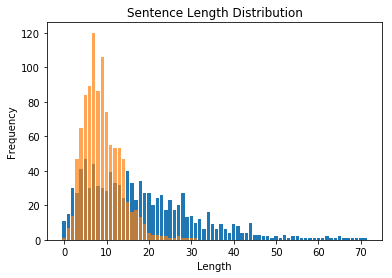

In [19]:

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())
ax.bar(range(len(hypo_count)), hypo_count.values(), alpha=0.7)

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [20]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))
print('Max word text: %d' % max_word_count_text)
print('Max word hypothesis: %d' % max_word_count_hypo)

Null word embeddings: -1
Found 5524
Total: 5837
Max word text: 171
Max word hypothesis: 46


In [21]:
s1_data = pad_sequences(sentence1_word_sequences, maxlen = max_seq_length)
s2_data = pad_sequences(sentence2_word_sequences, maxlen = max_seq_length)

labels = to_categorical(np.asarray(train_labels))

print('Shape of sentence1 tensor:', s1_data.shape)
print('Shape of sentence2 tensor:', s2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of sentence1 tensor: (1000, 20)
Shape of sentence2 tensor: (1000, 20)
Shape of label tensor: (1000, 3)


In [22]:
print('One sample')

print('Text: ')
print( train_sentence1[0] )

print('Word sequence: ')
print( sentence1_word_sequences[0] )

print('Pad: ')
print( s1_data[0] )

One sample
Text: 
Conceptually cream skimming has two basic dimensions - product and geography.
Word sequence: 
[3369, 1852, 2341, 31, 81, 1058, 3356, 767, 3, 2143]
Pad: 
[   0    0    0    0    0    0    0    0    0    0 3369 1852 2341   31
   81 1058 3356  767    3 2143]


# Tensor Model

## Helper methods.

In [23]:
eps = 1e-6

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def cosine_distance(y1, y2):
    mult =  tf.multiply(y1, y2)
    cosine_numerator = tf.reduce_sum( mult, axis = -1)
    y1_norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(y1), axis=-1 ), eps) ) 
    y2_norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(y2), axis=-1 ), eps) ) 
    return cosine_numerator / y1_norm / y2_norm

def cal_relevancy_matrix(text_vector, hypo_vector):
    text_vector_tmp = tf.expand_dims(text_vector, 1) # [batch_size, 1, question_len, dim]
    hypo_vector_tmp = tf.expand_dims(hypo_vector, 2) # [batch_size, passage_len, 1, dim]
    relevancy_matrix = cosine_distance(text_vector_tmp, hypo_vector_tmp) # [batch_size, passage_len, question_len]
    return relevancy_matrix

def mask_relevancy_matrix(relevancy_matrix, text_mask, hypo_mask):
    relevancy_matrix = tf.multiply(relevancy_matrix, K.expand_dims(text_mask, 1))
    relevancy_matrix = tf.multiply(relevancy_matrix, K.expand_dims(hypo_mask, 2))
    return relevancy_matrix

def max_mean_pooling(repres, cosine_matrix):
    
    repres.append(tf.reduce_max(cosine_matrix, axis = 2, keep_dims = True))
    repres.append(tf.reduce_mean(cosine_matrix, axis = 2, keep_dims = True))

    return repres

def matching_layer(inputs):
    forward_relevancy_matrix = cal_relevancy_matrix(inputs[0], inputs[2])
    backward_relevancy_matrix = cal_relevancy_matrix(inputs[1], inputs[3])

    representation = []

    max_mean_pooling(representation, forward_relevancy_matrix)
    max_mean_pooling(representation, backward_relevancy_matrix)
    
    return representation

## Matching layer

In [24]:
class MatchLayer(Layer):

    def __init__(self, dim, seq_length, **kwargs):
        super(MatchLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.dim = dim
        self.seq_length = seq_length
        
    def build(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('`MatchLayer` layer should be called '
                             'on a list of inputs')
        
        if all([shape is None for shape in input_shape]):
            return
        
        super(MatchLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs):
        if not isinstance(inputs, list):
            raise ValueError('A `MatchLayer` layer should be called ')
        
        return matching_layer(inputs)
    
    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('A `MatchLayer` layer should be called '
                             'on a list of inputs.')
        
        input_shapes = input_shape
        output_shape = list(input_shapes[0])
                             
        return [ (None, output_shape[1] , 1) ] * 4 
    
    def get_config(self):
        config = {

        }
        base_config = super(MatchLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class MaxPoolingLayer(Layer):

    def __init__(self, **kwargs):
        super(MaxPoolingLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaxPoolingLayer, self).build(input_shape)
    
    def call(self, inputs):
        return max_mean_pooling([], inputs)
    
    def compute_output_shape(self, input_shape):            
        output_shape = list(input_shape)
        return [ (None, output_shape[1] , 1) ] * 2
    
    def compute_mask(self, inputs, mask):
        return [mask, mask]


In [25]:
models = {};

def word_context(input, name):
    embedding = Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_seq_length,
                     trainable = False,
                     name = name + '_embedding')(input)
    
    word = Dropout(0.1)(embedding)

    context = Bidirectional(LSTM(100, return_sequences = True),
                            merge_mode = None,
                            name = name + '_context')(word)
    
    return (word, context)

def create_model():
    
    sentence1_input = Input(shape=(max_seq_length,), dtype='int32', name = 'text')
    sentence2_input = Input(shape=(max_seq_length,), dtype='int32', name = 'hypothesis')
    
    (text_embedding, text_context) = word_context(sentence1_input, 'text')
    (hypo_embedding, hypo_context) = word_context(sentence2_input, 'hypothesis')

    left_context = []
    left_context.extend(hypo_context)
    left_context.extend(text_context)
    
    left_match = MatchLayer(embedding_dim, max_seq_length)( left_context )
    
    right_context = []
    right_context.extend(text_context)
    right_context.extend(hypo_context)
    
    right_match = MatchLayer(embedding_dim, max_seq_length)( right_context )
    
    cosine_left = Lambda(lambda x_input: cal_relevancy_matrix(x_input[0], x_input[1]))( [text_embedding, hypo_embedding] )
    cosine_right = Lambda(lambda cosine: tf.transpose(cosine, perm=[0,2,1]))( cosine_left )
    
    left_representation = MaxPoolingLayer()( cosine_left )
    right_representation = MaxPoolingLayer()( cosine_right )
    
    left_representation.extend( left_match )
    right_representation.extend( right_match ) 
    
    left = concatenate(left_representation, axis = 2)
    left = Dropout(0.1)(left)
    
    right = concatenate(right_representation, axis = 2)
    right = Dropout(0.1)(right)
    

    aggregation_left = Bidirectional(LSTM(100),
                            name = 'aggregation_text_context')(left)
    
    aggregation_right = Bidirectional(LSTM(100),
                            name = 'aggregation_hypo_context')(right)
    
    aggregation = concatenate([aggregation_left, aggregation_right], axis = -1)
                               
    pred = Dense(200, activation = 'tanh', name = 'tanh_prediction')(aggregation)
    pred = Dense(3, activation = 'softmax', name = 'softmax_prediction')(pred)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model = Model(inputs=[sentence1_input, sentence2_input], outputs = pred)
    model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizer,
              metrics = ['accuracy'])
    
    print('Model created')
    
    return model


models['adam'] = create_model()



Model created


## Train Model

In [26]:
results = []
for name, model in models.items():
    callbacks = [
        BaseLogger(),
        ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=5, min_lr=0.001),
        TensorBoard(log_dir='./' + model_name + '-' + name + '-logs', histogram_freq=0, write_graph=True, write_images=True),
        ModelCheckpoint(model_name + '-' + name + '-checkpoint-weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', save_best_only=True)
    ]
    
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit([s1_data, s2_data],
                        labels,
                        epochs = epochs,
                        batch_size = batch_size,
                        validation_split = 0.1,
                        shuffle = False, #True,
                        verbose = 2,
                        callbacks = callbacks)

    model.save(model_name + '-' + name + '-model.h5')
    model.save_weights(model_name + '-' + name + '-weights.h5')

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    
    print('Time: %d' % (end_time - start_time))
    


Start learning adam at 1522351335
Epochs: 10
Batch size: 32
Train on 900 samples, validate on 100 samples
Epoch 1/10
10s - loss: 0.6391 - acc: 0.6626 - val_loss: 0.6186 - val_acc: 0.6667
Epoch 2/10
5s - loss: 0.6231 - acc: 0.6685 - val_loss: 0.6098 - val_acc: 0.6700
Epoch 3/10
4s - loss: 0.5597 - acc: 0.7089 - val_loss: 0.6116 - val_acc: 0.6933
Epoch 4/10
4s - loss: 0.4262 - acc: 0.8022 - val_loss: 0.6794 - val_acc: 0.6900
Epoch 5/10
4s - loss: 0.2739 - acc: 0.8874 - val_loss: 0.8892 - val_acc: 0.6600
Epoch 6/10
4s - loss: 0.2258 - acc: 0.9104 - val_loss: 0.8763 - val_acc: 0.6333
Epoch 7/10
4s - loss: 0.1315 - acc: 0.9522 - val_loss: 1.3152 - val_acc: 0.5900
Epoch 8/10
4s - loss: 0.0796 - acc: 0.9719 - val_loss: 1.1541 - val_acc: 0.6967
Epoch 9/10
4s - loss: 0.0934 - acc: 0.9693 - val_loss: 1.3536 - val_acc: 0.6067
Epoch 10/10
4s - loss: 0.0481 - acc: 0.9856 - val_loss: 1.3672 - val_acc: 0.6100
Time: 62


## Load weight for trained model

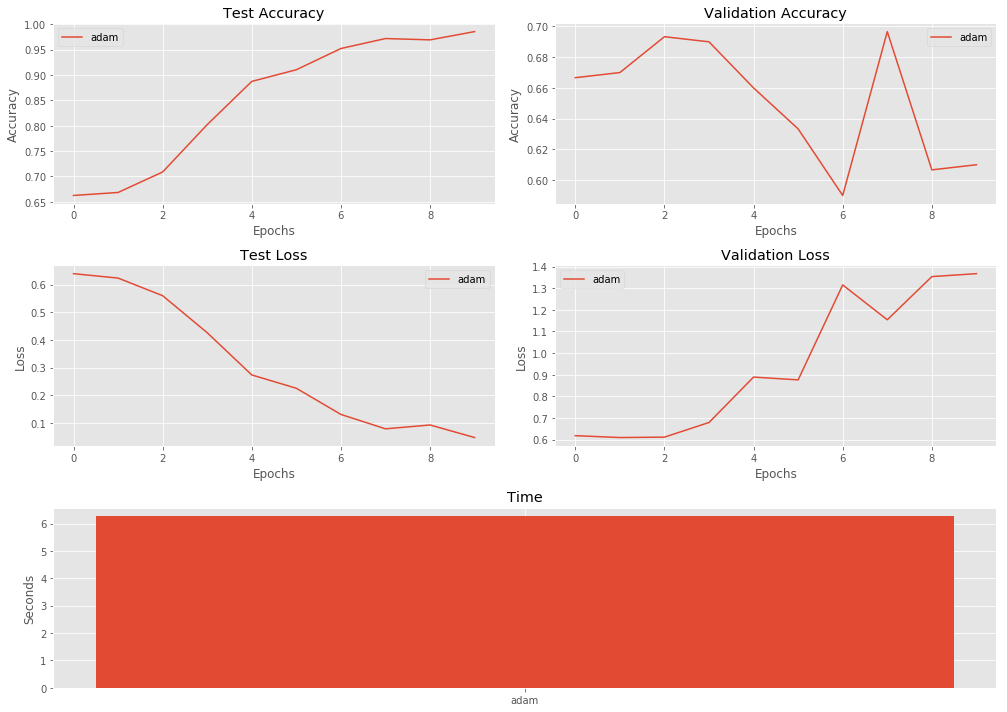

In [27]:
plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Test Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Test Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results], tick_label = models.keys(), align='center')

plt.tight_layout()
plt.savefig(model_name + '-acc-loss.png', dpi = 300)
plt.show()

# Test Matched

In [28]:
matched_filename = os.path.join(data_folder, dataset_filename, dataset_filename + '_dev_matched.jsonl')

(_, matched_sentence1, matched_sentence2, matched_labels_text) = loadDataset(matched_filename)

matched_s1_word_sequences = tokenizer.texts_to_sequences(matched_sentence1)
matched_s2_word_sequences = tokenizer.texts_to_sequences(matched_sentence2)

matched_s1_data = pad_sequences(matched_s1_word_sequences, maxlen = max_seq_length)
matched_s2_data = pad_sequences(matched_s2_word_sequences, maxlen = max_seq_length)
matched_labels = to_categorical(np.asarray(matched_labels_text))

print('Shape of test sentence1 tensor:', matched_s1_data.shape)
print('Shape of test sentence2 tensor:', matched_s2_data.shape)
print('Shape of test label tensor:', matched_labels.shape)

Label not recognized 185
Shape of test sentence1 tensor: (9815, 20)
Shape of test sentence2 tensor: (9815, 20)
Shape of test label tensor: (9815, 3)


In [29]:
for name, model in models.items():
    print('')
    print('Model %s' % name)
    
    loss, accuracy = model.evaluate([matched_s1_data, matched_s2_data], matched_labels)
    
    print('loss     = ', loss)
    print('accuracy = ', accuracy)


Model adam
9792/9815 [============================>.] - ETA: 0sloss     =  1.4871102788043884
accuracy =  0.6081508084213132


# Test Mismatched

In [30]:
mismatched_filename = os.path.join(data_folder, dataset_filename, dataset_filename + '_dev_mismatched.jsonl')
(_, mismatched_sentence1, mismatched_sentence2, mismatched_labels_text) = loadDataset(mismatched_filename)

mismatched_s1_word_sequences = tokenizer.texts_to_sequences(mismatched_sentence1)
mismatched_s2_word_sequences = tokenizer.texts_to_sequences(mismatched_sentence2)

mismatched_s1_data = pad_sequences(mismatched_s1_word_sequences, maxlen = max_seq_length)
mismatched_s2_data = pad_sequences(mismatched_s2_word_sequences, maxlen = max_seq_length)
mismatched_labels = to_categorical(np.asarray(mismatched_labels_text))

print('Shape of test sentence1 tensor:', mismatched_s1_data.shape)
print('Shape of test sentence2 tensor:', mismatched_s2_data.shape)
print('Shape of test label tensor:', mismatched_labels.shape)

Label not recognized 168
Shape of test sentence1 tensor: (9832, 20)
Shape of test sentence2 tensor: (9832, 20)
Shape of test label tensor: (9832, 3)


In [31]:
for name, model in models.items():
    loss, accuracy = model.evaluate([mismatched_s1_data, mismatched_s2_data], mismatched_labels)
    print('')
    print('Model %s' % name)
    print('loss     = ', loss)
    print('accuracy = ', accuracy)

9824/9832 [============================>.] - ETA: 0s
Model adam
loss     =  1.4714786992798596
accuracy =  0.6191687208545024
